I this notebook we take work from `003-multiple_PV_systems_v2` but perform more analysis of the PV systems to devise custom preprocesing steps and also to develop ideas about how to incorporate more physical knowledge as we can into the problem.

1. [Basic loading](#first_load)
2. [Distributions of the PV output](#PVdistributions)
3. [Cleaning](#cleaning)
4. [System capacity and max power](#system_capacity)
5. [Outlying PV output data](#PV_output_outliers)
6. [Clearsky irradiance](#clearsky)
7. [Solar panel orientation and daily PV curve](#orientation)
8. [Devising prediction values](#prediction_function)
9. [Fast GHI calculation](#ghi_calc)
10. [Transform data with GHI](#ghi_transform)
11. [Load satellite data](#load_sat)
12. [Load testing batch](#load_batches)
13. [Define neural net and train](#net)


In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import pandas as pd
import seaborn as sns
import os
import time
from datetime import timedelta
import rasterio.warp as rasteriowarp

In [2]:
# GLOBAL VARIABLES
SATELLITE_DATA_PATH = os.path.expanduser('~/repos/predict_pv_yield/data/projected_eumetsat/*/*')
PV_DATA_FILENAME = os.path.expanduser('~/repos/predict_pv_yield/data/PV/PVOutput.org/UK_PV_timeseries_batch.nc')
PV_METADATA_FILENAME = os.path.expanduser('~/repos/predict_pv_yield/data/PV/PVOutput.org/UK_PV_metadata.csv')

DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

# Geospatial boundary in Transverse Mercator projection (meters)
SOUTH = 5513500
NORTH = 6613500
WEST =  -889500
EAST =   410500

## Load and convert PV metadata
<a id='first_load'></a>

In [3]:
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col='system_id')
pv_metadata.dropna(subset=['longitude', 'latitude'], how='any', inplace=True) # drop systems with unknown location

In [4]:
pv_metadata.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,array_tilt_degrees,shade,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary
system_id,,,,,,,,,,,,,,,,,,,,
19397,AndyT's,3900,BS22,20,195,ZN Shine 195w,1,3500,Kaco 4202,S,30.0,No,2011-11-21 00:00:00,51.36,-2.92,5,0,0,NaN,NaN
8195,Kilmarnock Roof,3750,KA3,15,250,Sanyo 250 HIT,1,4000,Omniksol,S,30.0,No,2011-11-07 00:00:00,55.64,-4.49,10,0,0,NaN,NaN
8200,Flat 5,3430,E8,14,245,NaN,1,3000,sb3000,S,25.0,Low,2011-12-12 00:00:00,51.54,-0.06,5,0,0,NaN,NaN
8204,Sooper-Dooper Solar,2940,GU2,12,245,SunTech STP245S-20/Wd,1,3000,Kaco Powador 3002,S,19.0,No,2012-05-11 00:00:00,51.24,-0.59,10,0,0,NaN,NaN
8205,58GPR,4000,BS48,16,250,Sanyo component Europe GmbH,1,50,Sma sunny boysb3800v,S,NaN,No,2011-11-10 00:00:00,51.42,-2.74,10,0,0,NaN,NaN


In [5]:
# Convert lat lons to Transverse Mercator
pv_metadata['x'], pv_metadata['y'] = rasteriowarp.transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=pv_metadata['longitude'].values,
    ys=pv_metadata['latitude'].values)

# Filter 3 PV systems which apparently aren't in the UK!
pv_metadata = pv_metadata[
    (pv_metadata.x >= WEST) &
    (pv_metadata.x <= EAST) &
    (pv_metadata.y <= NORTH) &
    (pv_metadata.y >= SOUTH)]

len(pv_metadata)

2548

## Load and normalise PV power data

In [6]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME)

CPU times: user 14.1 s, sys: 4 s, total: 18.1 s
Wall time: 25.4 s


In [7]:
pv_power_selected = pv_power.loc[dict(datetime=slice('2018-07-01', '2019-07-10'))]
pv_power_selected.head()

<xarray.Dataset>
Dimensions:   (datetime: 5)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-07-01T03:30:00 ... 2018-07-01T03:50:00
Data variables:
    10003     (datetime) float32 nan nan nan nan nan
    10012     (datetime) float32 nan nan nan nan nan
    10020     (datetime) float32 nan nan nan nan nan
    10033     (datetime) float32 nan nan nan nan nan
    10041     (datetime) float32 nan nan nan nan nan
    10078     (datetime) float32 nan nan nan nan nan
    10104     (datetime) float32 nan nan nan nan nan
    10125     (datetime) float32 nan nan nan nan nan
    10154     (datetime) float32 nan nan nan nan nan
    10156     (datetime) float32 nan nan nan nan nan
    10232     (datetime) float32 nan nan nan nan nan
    10246     (datetime) float32 nan nan nan nan nan
    10332     (datetime) float32 nan nan nan nan nan
    10333     (datetime) float32 nan nan nan nan nan
    10334     (datetime) float32 nan nan nan nan nan
    10370     (datetime) float32 nan nan nan nan nan
    10377     (datetime) float32 nan nan nan nan nan
    10387     (datetime) float32 nan nan nan nan nan
    10427     (datetime) float32 nan nan nan nan nan
    10455     (datetime) float32 nan nan nan nan nan
    10493     (datetime) float32 nan nan nan nan nan
    10509     (datetime) float32 nan nan nan nan nan
    10510     (datetime) float32 nan nan nan nan nan
    10534     (datetime) float32 nan nan nan nan nan
    10589     (datetime) float32 nan nan nan nan nan
    10593     (datetime) float32 nan nan nan nan nan
    10606     (datetime) float32 nan nan nan nan nan
    10610     (datetime) float32 nan nan nan nan nan
    10674     (datetime) float32 nan nan nan nan nan
    10899     (datetime) float32 nan nan nan nan nan
    10903     (datetime) float32 nan nan nan nan nan
    10968     (datetime) float32 nan nan nan nan nan
    11144     (datetime) float32 nan nan nan nan nan
    11167     (datetime) float32 nan nan nan nan nan
    11225     (datetime) float32 nan nan nan nan nan
    11240     (datetime) float32 nan nan nan nan nan
    11259     (datetime) float32 nan nan nan nan nan
    11514     (datetime) float32 nan nan nan nan nan
    11515     (datetime) float32 nan nan nan nan nan
    11516     (datetime) float32 nan nan nan nan nan
    11542     (datetime) float32 nan nan nan nan nan
    11610     (datetime) float32 nan nan nan nan nan
    11683     (datetime) float32 7.0 nan 7.0 nan 7.0
    11790     (datetime) float32 nan nan nan nan nan
    11812     (datetime) float32 nan nan nan nan nan
    11842     (datetime) float32 13.0 17.0 17.0 23.0 36.0
    11909     (datetime) float32 nan nan nan nan nan
    11942     (datetime) float32 nan nan nan nan nan
    12057     (datetime) float32 nan nan nan nan nan
    12084     (datetime) float32 nan nan nan nan nan
    12099     (datetime) float32 nan nan nan nan nan
    12290     (datetime) float32 nan nan nan nan nan
    12314     (datetime) float32 nan nan nan nan nan
    12322     (datetime) float32 52.0 67.0 70.0 66.0 75.0
    12338     (datetime) float32 nan nan nan nan nan
    12384     (datetime) float32 nan nan nan nan nan
    12406     (datetime) float32 nan nan nan nan nan
    1241      (datetime) float32 nan nan nan nan nan
    12485     (datetime) float32 nan nan nan nan nan
    12486     (datetime) float32 nan nan nan nan nan
    12520     (datetime) float32 nan nan nan nan nan
    12570     (datetime) float32 nan nan nan nan nan
    12621     (datetime) float32 nan nan nan nan nan
    12698     (datetime) float32 nan nan nan nan nan
    12756     (datetime) float32 nan nan nan nan nan
    12820     (datetime) float32 nan nan nan nan nan
    12896     (datetime) float32 nan nan nan nan nan
    13034     (datetime) float32 nan nan nan nan nan
    13043     (datetime) float32 nan nan nan nan nan
    13044     (datetime) float32 nan nan nan nan nan
    13064     (datetime) float32 nan nan nan nan nan
    13120     (datetime) float32 nan nan nan nan nan
    13129     (d

In [8]:
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')

In [9]:
print(f"total power output of these PV systems is {pv_power_df.sum(axis=1).resample('1H').mean().sum() * 1e-9 * 365/(pv_power_df.index[-1]- pv_power_df.index[0]).days: .2f} GWhrs / year")

total power output of these PV systems is  2.42 GWhrs / year


## Distributions of PV output power
<a id='PVdistributions'></a>

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


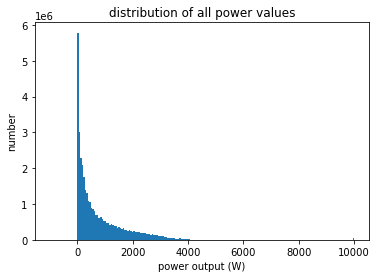

In [10]:
plt.hist(pv_power_df.clip(-1000, 10000).values.ravel(), bins=200);
plt.xlabel('power output (W)')
plt.ylabel('number')
plt.title('distribution of all power values')
plt.show()

In [11]:
pvlim = 50000
print(f'{np.any(pv_power_df < 0, axis=0).mean()*100:.2f}% of systems ({np.any(pv_power_df < 0, axis=0).sum()} systems total) have negative readings ever')
print(f'{np.any(pv_power_df > pvlim, axis=0).mean()*100:.2f}% of systems ({np.any(pv_power_df > pvlim, axis=0).sum()} systems total) have power reading over reaching over {pvlim}')

0.74% of systems (7 systems total) have negative readings ever
0.21% of systems (2 systems total) have power reading over reaching over 50000


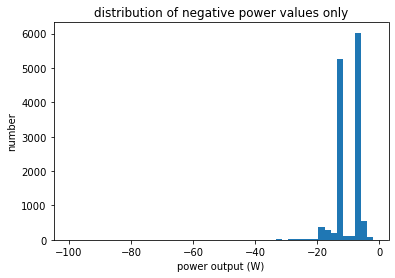

In [12]:
plt.hist(pv_power_df.where(lambda x: x<0 ).clip(-100).values.ravel(), bins=50);
plt.xlabel('power output (W)')
plt.ylabel('number')
plt.title('distribution of negative power values only')
plt.show()

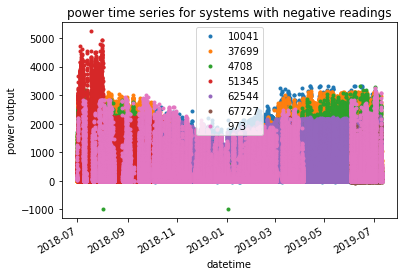

In [13]:
pv_power_df.loc[:,np.any(pv_power_df < 0, axis=0)].clip(-1000).plot(style='.')
plt.ylabel('power output')
plt.title('power time series for systems with negative readings')
plt.show()

Above the systems with negative power reading don't seem to have completely unusable data. Instead there seems to be only a few points which are erroneous. This suggests that removing these points only, rather than all of the data from these systems may be a reasonable response.

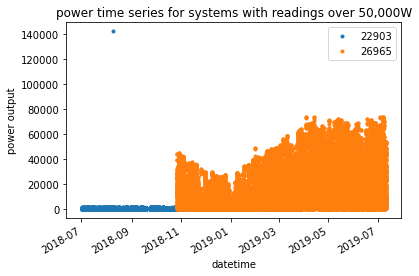

In [14]:
pv_power_df.loc[:,np.any(pv_power_df > pvlim, axis=0)].plot(style='.')
plt.ylabel('power output')
plt.title(f'power time series for systems with readings over {pvlim:,}W')
plt.show()

Above one of these systems seems to have a outlier, the other appears to be a system with large capacity. This needs more analysis, shown further below.

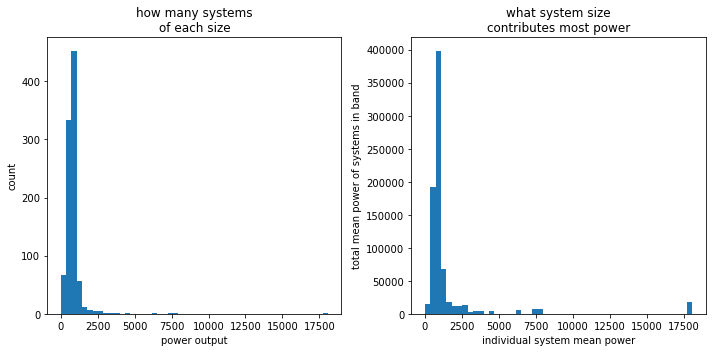

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex = True, figsize=(10,5))
nbins = 50

ax1.hist(pv_power_df.clip(0).mean(axis=0), bins=nbins)
ax1.set_xlabel('power output')
ax1.set_ylabel('count')
ax1.set_title('how many systems\nof each size')

df_ = pv_power_df.clip(0).mean(axis=0)
df_ = df_.groupby(pd.cut(df_, nbins)).sum()

bins =  [0] + [ind.right for ind in df_.index]
x =  [ind.mid for ind in df_.index]
ax2.hist(x, weights = df_, bins=bins)
ax2.set_xlabel('individual system mean power')
ax2.set_ylabel('total mean power of systems in band')
ax2.set_title('what system size\ncontributes most power')

plt.tight_layout()
plt.show()


Above most of the power comes from smaller systems with average power < 1085. This is good to know so that our full forecast wouldn't be dominated by a single PV system. Although this may be the case in some GSPs.

## A little data cleaning
This cleaning was brought forward from the previous notebook
<a id='cleaning'></a>

In [16]:
pv_power_df = pv_power_df.clip(lower=0)
pv_power_df.columns = pv_power_df.columns.astype(int)
pv_power_df = pv_power_df.tz_localize('Europe/London').tz_convert('UTC')

In [17]:
del pv_power
del pv_power_selected

In [18]:
# A bit of hand-crafted cleaning
pv_power_df[30248]['2018-10-29':'2019-01-03'] = np.NaN
pv_power_df[22903]['2018-08-08'] = np.NaN

In [19]:
# Only pick PV systems for which we have good metadata
def align_pv_system_ids(pv_metadata, pv_power_df):
    pv_system_ids = pv_metadata.index.intersection(pv_power_df.columns)
    pv_system_ids = np.sort(pv_system_ids)

    pv_power_df = pv_power_df[pv_system_ids]
    pv_metadata = pv_metadata.loc[pv_system_ids]
    return pv_metadata, pv_power_df
    
pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)

## System capacity and max power
<a id='system_capacity'></a>
Do the metadata PV system capcity and inverter size define the max power output of a system?

In [20]:
# add the 99th percentile max power output
pv_metadata_plus = pv_metadata.join(pd.Series(np.nanpercentile(pv_power_df, 99, axis=0), index = pv_power_df.columns, name='max_output'))

Text(27.0, 0.5, 'max_output / system_size_watts')

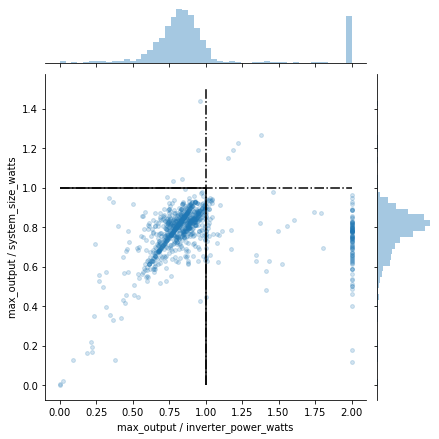

In [21]:
clipat = 2
# max_output / inverter_power_watts and max_output / system_size_watts
x, y = (pv_metadata_plus.loc[:, ['inverter_power_watts', 'system_size_watts']].values.astype(float)**-1 * pv_metadata_plus.loc[:, ['max_output']].values).T.clip(0,clipat)

ax = sns.jointplot(x, y, joint_kws=dict(alpha=0.2, s=15)).ax_joint

ax.hlines(1,0,1)
ax.hlines(1,0, clipat, linestyles='-.')
ax.vlines(1,0,1)
ax.vlines(1,0,1.5, linestyles='-.')
ax.set_xlabel('max_output / inverter_power_watts')
ax.set_ylabel('max_output / system_size_watts')

The above plot shows us that the measured max power output isn't necessarily capped by the system size and the inverter size as stated in the metadata. This points to some erroneoud data in either the metadata or in the PV output. In the table below you can see that for the same system name people have enetered different values for the inverter power. Also in the graph above, those systems with max output more than double (note the clip at value of 2) are likely mircoinverter systems. All this goes to say that it would be very difficult to use the metadata to define the max output of each system. Better just to measure it from the time series - despite the potential outliers as show further above. 

In [22]:
from scipy import stats
agg_operations1 = ['max', stats.mode,'min','count']
agg_operations2 = ['max', np.median,'min','count']
pv_metadata_plus.groupby('inverter_brand').agg({'inverter_power_watts':agg_operations1, 'max_output':agg_operations2}).sort_values(by=('inverter_power_watts', 'count'), ascending=False).head(20)

inverter_power_watts                              \
                                         max            mode   min count   
inverter_brand                                                             
SolarEdge SE4000                        4000  ([3680], [32])  3680    42   
SolarEdge SE3680                        3680  ([3680], [30])  3680    30   
SolarEdge                               9380   ([4000], [8])  2200    28   
SMA                                    40000   ([4000], [6])  1000    28   
SMA Sunny Boy 4000TL                    4000  ([4000], [21])  4000    21   
Solaredge                              10000   ([4000], [7])  3000    21   
Enphase                                 4500    ([250], [5])   100    18   
Energy Monitor                          4000    ([50], [10])    50    15   
Enecsys 240                              240   ([240], [14])   240    14   
Enphase M215                            4000    ([215], [4])   215    12   
SMA Sunny Boy                           5000   ([3600], [3])    50    12   
SMA Sunny Boy 4000                      4000  ([4000], [11])  3800    12   
SMA Sunny Boy 4000TL-20                 4000  ([4000], [11])  4000    11   
SolarEdge SE3000                        3000  ([3000], [11])  3000    11   
SMA 4000TL                              4000  ([4000], [10])    50    11   
Enecsys                                 4000    ([240], [3])   240    10   
Trannergy                               4600   ([4000], [6])  3500     8   
Solar Edge                              4000   ([4000], [6])   350     8   
Aurora                                  3600   ([3600], [6])    50     7   
SMA Sunny Boy 3600TL                    4000   ([3600], [3])  3600     7   

                        max_output                           
                               max    median      min count  
inverter_brand                                               
SolarEdge SE4000           5658.88  3177.660  2206.61    42  
SolarEdge SE3680           3684.00  3301.290  2415.00    30  
SolarEdge                  7185.60  3282.380  1404.00    28  
SMA                       27481.47  2730.000   864.00    28  
SMA Sunny Boy 4000TL       3705.00  3300.000  1776.00    21  
Solaredge                  8672.11  3424.000  2007.00    21  
Enphase                    6384.76  3023.000   588.00    18  
Energy Monitor             5454.00  2876.090     1.00    15  
Enecsys 240                2777.00  2277.985  1126.00    14  
Enphase M215              65413.14  2784.000  1585.00    12  
SMA Sunny Boy              3527.00  2952.000   443.04    12  
SMA Sunny Boy 4000         3492.00  3150.000  2427.18    12  
SMA Sunny Boy 4000TL-20    4008.00  3121.000  2484.00    11  
SolarEdge SE3000           2546.00  2321.000  1747.00    11  
SMA 4000TL                 3540.00  3180.000  2028.00    11  
Enecsys                    4601.00  2675.850  1427.00    10  
Trannergy                  3872.55  3376.090  2712.00     8  
Solar Edge                 3543.00  2851.500  1424.00     8  
Aurora                     3674.00  3389.830  2642.64     7  
SMA Sunny Boy 3600TL       3528.00  3336.000  3180.00     7

## Outlying PV output data
<a id='PV_output_outliers'></a>

In [23]:
# scale to range [0, 1]
pv_power_min = pv_power_df.min()
pv_power_max = pv_power_df.max()

pv_power_df -= pv_power_min
pv_power_df /= pv_power_max

In [24]:
# Find systems which are producing over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = [*range(21, 24)] + [*range(0, 4)]
bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum()
)[0]
bad_systems = pv_power_df.columns[bad_systems]
pv_power_bad_df = pv_power_df[bad_systems]

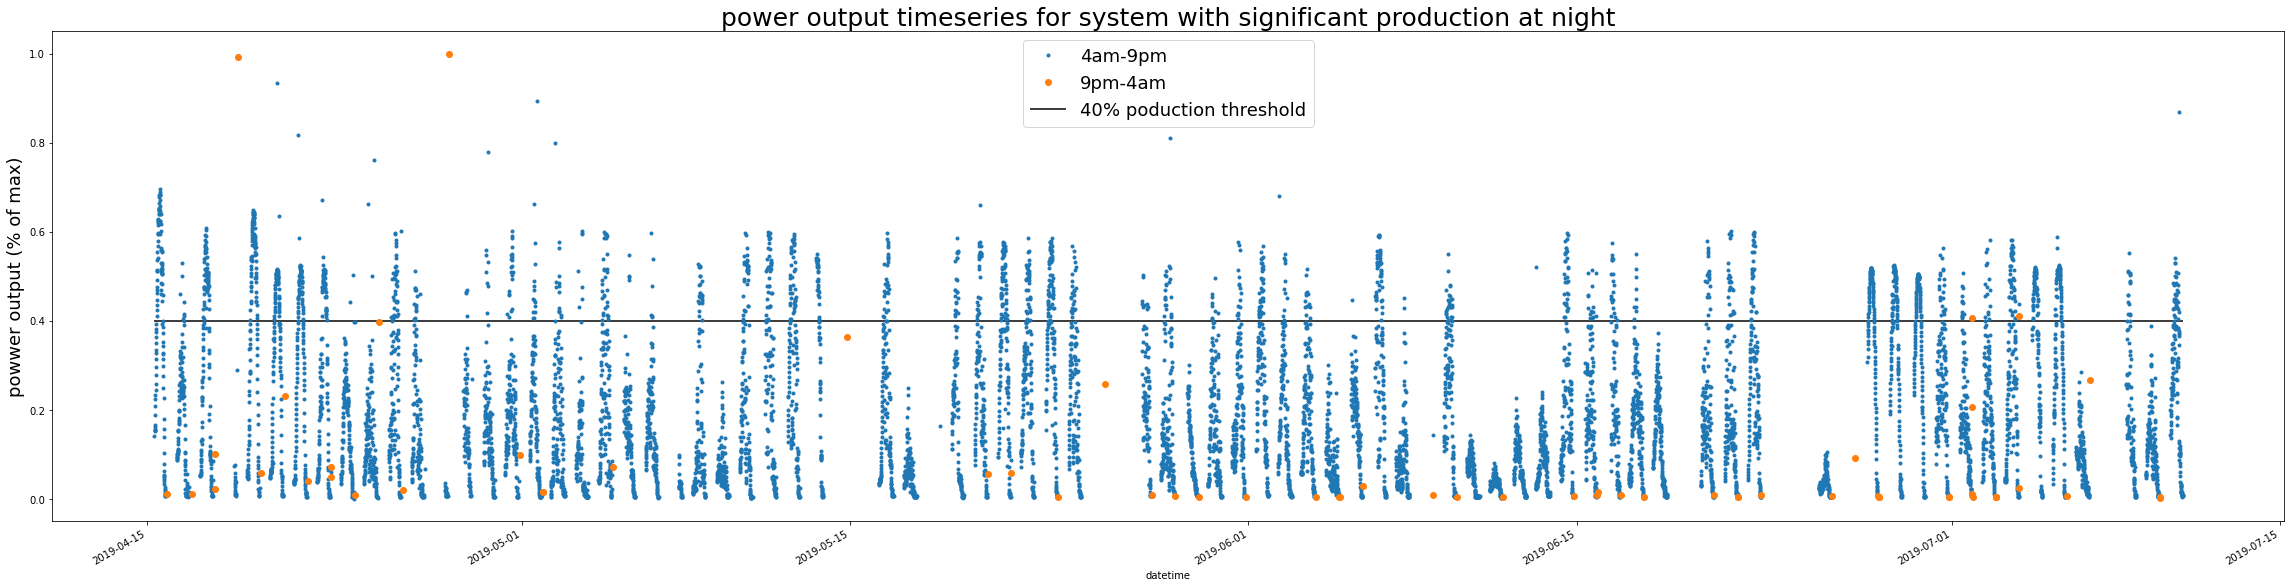

In [25]:
df_ = pv_power_bad_df.iloc[:,0].dropna()
ax = df_.plot(figsize=(40, 10), style='.', label='4am-9pm')
df_[df_.index.hour.isin(night_hours)].plot(ax=ax, style='o', label='9pm-4am')
plt.hlines(0.4, df_.index.min(), df_.index.max(), label='40% poduction threshold')
plt.ylabel('powwer output (% of max)', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.title('power output timeseries for system with significant production at night', fontsize=25)
del df_

The above plot (also considering when a different bad system is picked) shows us that the ones that report significant power output over night generally have outliers in the day as well. Also note that the max power output for normalisation has been inflated due to outliers. Therefore the power fractions don't ever get very high. I don't think these outliers really reflect sunny days. It is also interesting that most have nan data durng the night.

In [26]:
pv_power_df.drop(bad_systems, axis='columns', inplace=True)

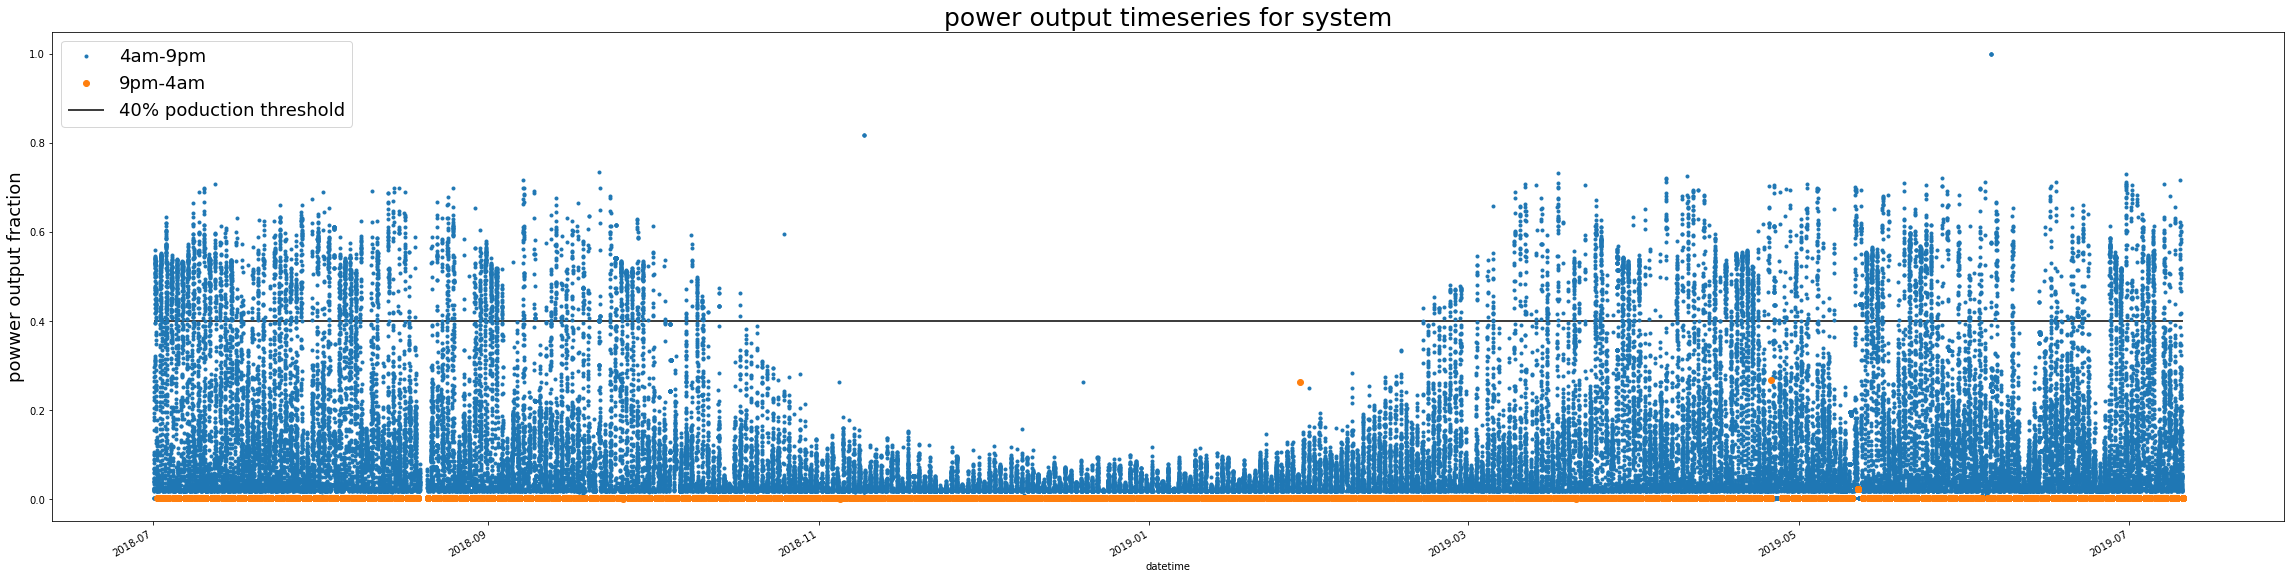

In [27]:
df_ = pv_power_df.iloc[:, 19].dropna()
ax = df_.plot(figsize=(40, 10), style='.', label='4am-9pm')
df_[df_.index.hour.isin(night_hours)].plot(ax=ax, style='o', label='9pm-4am')
plt.hlines(0.4, df_.index.min(), df_.index.max(), label='40% poduction threshold')
plt.ylabel('powwer output fraction', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.title('power output timeseries for system', fontsize=25)
del df_

As shown above even some of the non-bad systems have outliers which inflate their max powers. This suggests some outlier detection might be beneficial first. Or at least some more robust scaling.

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted


class RobustMinMaxScaler(MinMaxScaler):

    def __init__(self, feature_range=(0, 1), saturation_fraction=0.01, copy=True):
        self.feature_range = feature_range
        self.copy = copy
        self.saturation_fraction = saturation_fraction

    def partial_fit(self, X, y=None):
        """
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data used to compute the min and max
            used for later scaling along the features axis.
        y : None
            Ignored.
        Returns
        -------
        self : object
            Transformer instance.
        """
        percentile_min = self.saturation_fraction*100
        percentile_max = (1-self.saturation_fraction)*100

        robust_data_min = np.nanpercentile(X, percentile_min, axis=0)
        robust_data_max = np.nanpercentile(X, percentile_max, axis=0)
        
        self.robust_data_min = robust_data_min
        self.robust_data_max = robust_data_max
        
        Xr = X.clip(self.robust_data_min, self.robust_data_max, axis=1)
        
        return super().partial_fit(Xr, y=y)
        


    def transform(self, X):
        """Scale features of X according to feature_range.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data that will be transformed.
        Returns
        -------
        Xt : array-like of shape (n_samples, n_features)
            Transformed data.
        """
        check_is_fitted(self)
        Xr = X.clip(self.robust_data_min, self.robust_data_max, axis=1)
        
        return super().transform(Xr)
    

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [29]:
# Robustly scale to the range [0, 1]
scalar = RobustMinMaxScaler(saturation_fraction=0.005)
pv_power_df_orig = pv_power_df
pv_power_df_new = pd.DataFrame(scalar.fit_transform(pv_power_df) , columns = pv_power_df.columns, index = pv_power_df.index)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


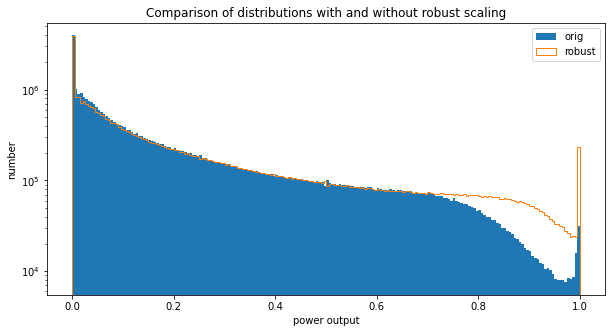

In [30]:
plt.figure(figsize=(10,5))
plt.hist(pv_power_df_orig.clip(-1000, 10000).values.ravel(), bins=200, label='orig', histtype='bar');
plt.hist(pv_power_df_new.clip(-1000, 10000).values.ravel(), bins=200, label='robust', histtype='step');
plt.xlabel('power output')
plt.ylabel('number')
plt.yscale('log')
plt.title('Comparison of distributions with and without robust scaling')
plt.legend(loc='best')
plt.show()

This looks like a good change to the distrbution. By setting the upper and lower limits to 0.5% and 99.5% we've changed the lower part of the distribution very little but increased the ddenbsity at the upper end of the distribution - presumably by clipping outlying false max values. If used for predictions this would mean that we would never capture the power between the 99.5 and 100th percentile, but I suspect that is only a small amount and worth the trade off. Without this rescaling our network would otherwise see max output conditions for some systems but be trained to evaluate these as submax output due to the scaling from the outliers.

In [31]:
del pv_power_df_orig
pv_power_df = pv_power_df_new
del pv_power_df_new

Lets look again for bad systems with new scaling and remove these

In [32]:
updated_bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum()
)[0]
updated_bad_systems = pv_power_df.columns[updated_bad_systems]
pv_power_bad_df = pv_power_df[updated_bad_systems]
pv_power_df.drop(updated_bad_systems, axis='columns', inplace=True)

In [33]:
%%time
# Interpolate up to 15 minutes ahead.
pv_power_df = pv_power_df.interpolate(limit=3)

CPU times: user 24.4 s, sys: 1.33 s, total: 25.7 s
Wall time: 25.7 s


In [34]:
# Align again, after removing dud PV systems
pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)

## Clearsky irradiance
<a id='clearsky'></a>

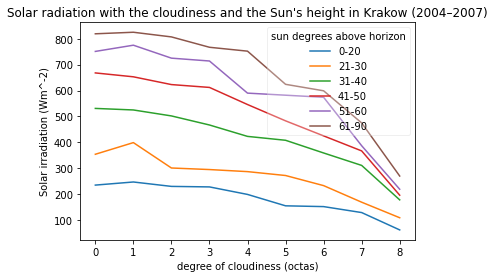

In [35]:
# data from https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.2432

df_ = pd.DataFrame(
    np.array([
            [235, 354, 531, 668, 751, 819], 
            [247, 399, 525, 653, 775, 825], 
            [230, 301, 502, 623, 725, 807], 
            [228, 295, 467, 612, 714, 767], 
            [199, 287, 423, 546, 590, 752], 
            [155, 272, 408, 483, 582, 624], 
            [152, 233, 359, 425, 574, 599], 
            [129, 169, 311, 367, 387, 475], 
            [62, 109, 178, 196, 219, 270], 
    ]),
    index=pd.Series(range(9), name='cloudiness'),
    columns=pd.IntervalIndex.from_tuples([(0,20),(21,30), (31,40), (41, 50), (51,60), (61, 90)])
)

for i in range(len(df_.columns)):
    plt.plot(df_.iloc[:,i], label='{}-{}'.format(df_.columns[i].left, df_.columns[i].right))
plt.legend(title="sun degrees above horizon", framealpha=0.3, loc='best')
plt.xlabel('degree of cloudiness (octas)')
plt.ylabel('Solar irradiation (Wm^-2)')
plt.title("Solar radiation with the cloudiness and the Sun's height in Krakow (2004–2007)")
plt.show()

Thankfully the above plot shows that the proportion of masking by clouds is approximately independent of solar angle.


Although in the same paper as the data came from (https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.2432) they say 

> When Cirrus and Cirrostratus clouds are present in the sky, the Sun's height above the horizon is a crucial factor. When the Sun's height is low (h < 20°), the transmitted radiation is largely limited; solar radiation intensity is approximately 45% lower than it would be if the Sun's height were high (h > 60°).

In [36]:
import pvlib
from pvlib.location import Location

In [37]:
def get_pvlib_location(pv_system_id):
    return Location(
        latitude=pv_metadata['latitude'][pv_system_id],
        longitude=pv_metadata['longitude'][pv_system_id],
        tz='UTC',
        name=pv_metadata['system_name'][pv_system_id])

In [38]:
def calculate_time_bin_means(series, delta_t):
    """Given a time series and a time bin width construct a new series 
    of mean values in each bin going forward from the start of the series."""
    rolling_series=[]
    dates = []
    t = series.index[0]
    while t < series.index[-1]:
        dates.append(t)
        rolling_series.append(series.loc[t:t+delta_t].mean())
        t+=delta_t
    new_index = pd.to_datetime(dates)
    new_index.name = series.index.name
    return pd.Series(rolling_series, index=new_index, name=series.name)

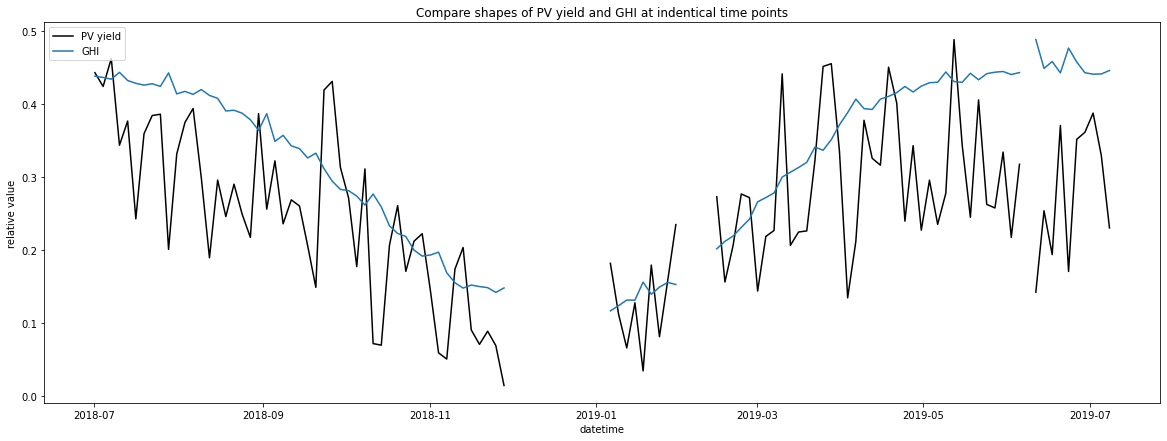

In [39]:
pv_system_id = pv_metadata.index[9]
delta_t = timedelta(hours=72)

# GHI and pv output at a single location
pv_data_to_plot = pv_power_df[pv_system_id].dropna()
location = get_pvlib_location(pv_system_id)
clearsky = location.get_clearsky(pv_data_to_plot.index).ghi

# calculate binned means
pv_data_to_plot = calculate_time_bin_means(pv_data_to_plot, delta_t)
clearsky = calculate_time_bin_means(clearsky, delta_t)


plt.figure(figsize=(20, 7))
plt.plot(pv_data_to_plot, label='PV yield', color='k')
plt.plot(clearsky/clearsky.max() * pv_data_to_plot.max(), label='GHI')
plt.legend(loc='upper left')
plt.ylabel('relative value')
plt.xlabel('datetime')
plt.title('Compare shapes of PV yield and GHI at indentical time points')
plt.show()

The above plot and the one below show that GHI is a pretty informative feature for PV power as expected

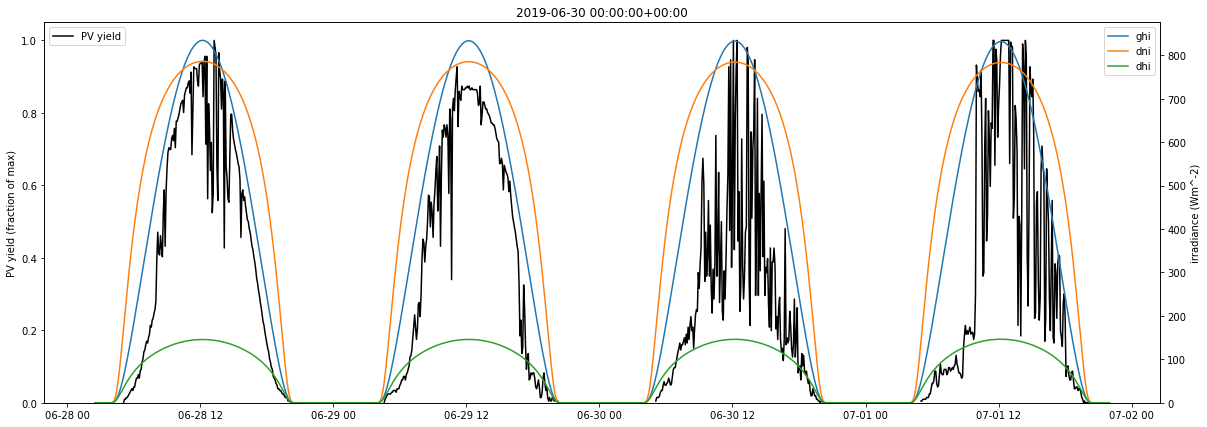

In [40]:
dt = pd.Timestamp('2019-06-30', tz='UTC')


pv_data_to_plot = pv_power_df[pv_system_id][dt - timedelta(hours=48):dt + timedelta(hours=48)]
clearsky = location.get_clearsky(pv_data_to_plot.index)

fig, ax = plt.subplots(figsize=(20, 7))
ax2 = ax.twinx()

ax.plot(pv_data_to_plot, label='PV yield', color='k')

lines = ax2.plot(clearsky)
for line, label in zip(lines, clearsky.columns):
    line.set_label(label);
    
ax.set_title(dt)

ax.set_ylim((0, None))
ax2.set_ylim((0, None))

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_ylabel('PV yield (fraction of max)')
ax2.set_ylabel('irradiance (Wm^-2)')

plt.show()

GHI is the most relevant of these clearsky indices. In `pvlib` there are multiple ways in which this can be calculated. We need to choose one.

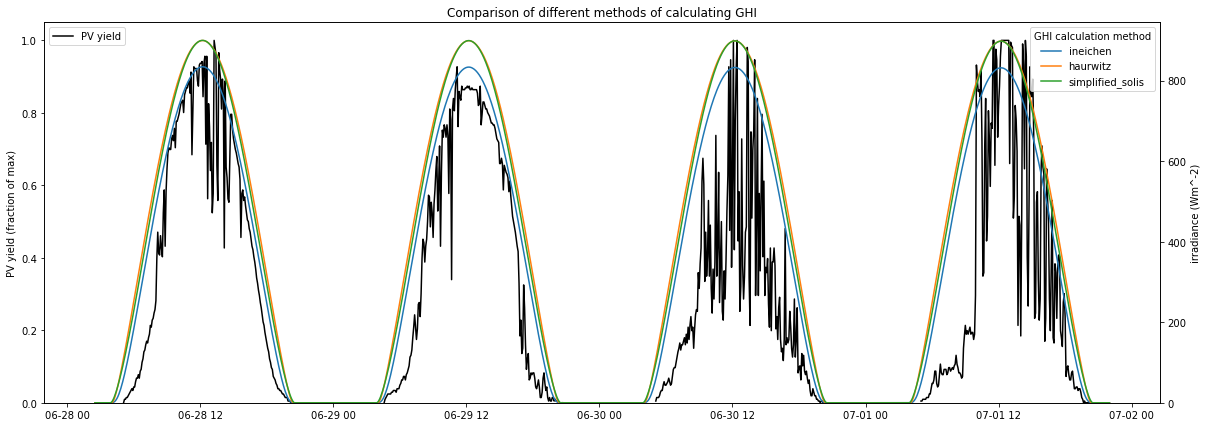

In [41]:

pv_data_to_plot = pv_power_df[pv_system_id][dt - timedelta(hours=48):dt + timedelta(hours=48)]

fig, ax = plt.subplots(figsize=(20, 7))
ax2 = ax.twinx()

ax.plot(pv_data_to_plot, label='PV yield', color='k')

for model in ['ineichen', 'haurwitz', 'simplified_solis']:
    clearsky = location.get_clearsky(pv_data_to_plot.index, model=model).ghi
    line = ax2.plot(clearsky)[0]
    line.set_label(model);
        
ax.set_title('Comparison of different methods of calculating GHI')

ax.set_ylim((0, None))
ax2.set_ylim((0, None))

ax.legend(loc='upper left')
ax2.legend(loc='upper right', title='GHI calculation method')

ax.set_ylabel('PV yield (fraction of max)')
ax2.set_ylabel('irradiance (Wm^-2)')

plt.show()

The simplest method in terms of calculation is Haurwitz, so we will choose that for now as it seems reasonably close to simplified_solis and doesn't require data lookup

## Solar panel orientation and daily PV curve
<a id='orientation'></a>

Is orientation an informative feature?

In [42]:
# postcodes areas with most systems so we can control for location
pv_metadata.groupby(pv_metadata.postcode.str.slice(0,2)).agg({'system_name':'count'}) \
           .sort_values(by='system_name',ascending=False).head() \
           .rename({'system_name':'number of systems'}, axis=1)

,number of systems
postcode,
PL,54
TR,31
RG,30
PE,26
CB,25


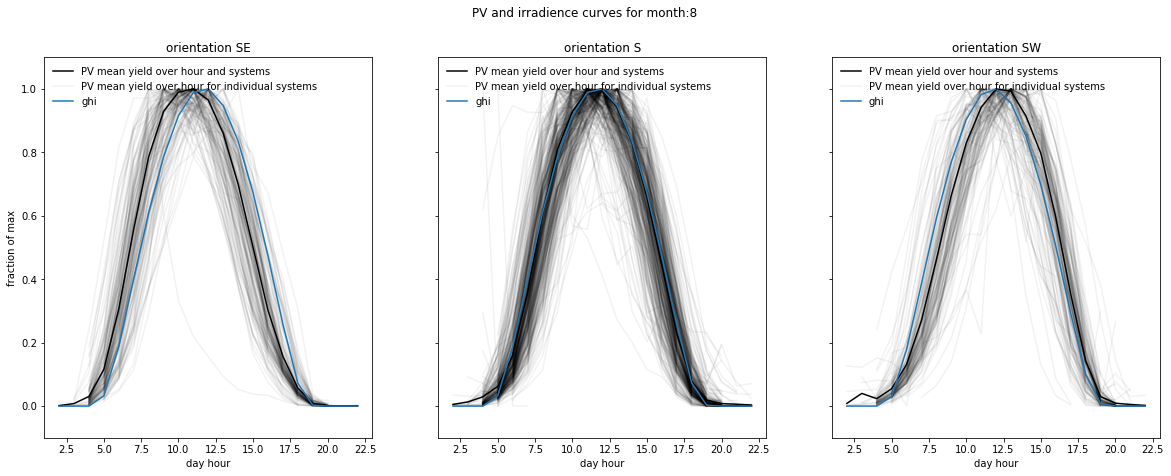

In [43]:
fig, axes = plt.subplots(1,3,figsize=(20, 7), sharex=True, sharey=True)


postcode_start = ''                # filter by postcode start
month = 8                          # filter to month
orientations = ['SE', 'S', 'SW']   # group to these orientations

for ax, orientation in zip(axes, orientations):

    postcode_index = pv_metadata.query("postcode.str.startswith(@postcode_start).fillna(False)",  engine='python').query("orientation==@orientation").index

    pv_data_to_plot = pv_power_df.loc[:,pv_power_df.columns.intersection(postcode_index)][pv_power_df.index.month==month]
    pv_data_to_plot_hour_mean = pv_data_to_plot.groupby(pv_data_to_plot.index.hour).mean()
    pv_data_to_plot_hour_mean /= pv_data_to_plot_hour_mean.max()
    pv_data_to_plot_hour_system_means = pv_data_to_plot_hour_mean.mean(axis=1)
    pv_data_to_plot_hour_system_means /= pv_data_to_plot_hour_system_means.max()

    ax.plot(pv_data_to_plot_hour_system_means, label='PV mean yield over hour and systems', color='k')
    all_lines = ax.plot(pv_data_to_plot_hour_mean, color='k', zorder=-1, alpha=0.05)
    all_lines[0].set_label('PV mean yield over hour for individual systems')
    
    location  = get_pvlib_location(pv_data_to_plot.columns[0]) # sample one location from area
    clearsky = location.get_clearsky(pv_data_to_plot.index).loc[:, ['ghi']]
    clearsky_hour_mean = clearsky.groupby(clearsky.index.hour).mean()
    clearsky_hour_mean /= clearsky_hour_mean.max()

    clearsky_hour_mean.plot(ax=ax)

    ax.set_ylim((-.1, 1.1))
    ax.legend(loc='upper left', framealpha=0)
    ax.set_ylabel('fraction of max')
    ax.set_xlabel('day hour')
    subtitle = f"orientation {orientation}" 
    ax.set_title(subtitle)

title = f'PV and irradience curves for month:{month}'
if postcode_start != '': title+=f" in postcode areas:{postcode_start}"
fig.suptitle(title)
plt.show()

In the graph above we can see that the orientation of the panel SE as opposed to S shifts the mean PV output curve by about an hour earlier (opposite is true for SW). So orientation will likely be a good feature to include for prediction. Also looking at the individual curves it seems like some of the orientations may be wrong. Some S orientation curves look distinctly like they should be SE or SW and vice versa. Perhaps we could use these curves to infer their orientation?

## Devising prediction values
<a id='prediction_function'></a>

I think the value we want to predict is $k(x)$ - how much of the radiation the system could have captured actually made it in.

Where the total power produced by the PV system is therefore 

$$PV = GHI(t, \theta)A(\lambda)k(x)$$

Where $t$ is the datetime and $\theta$ is the location and orientation (ie S, SW, SE etc) of the system and $GHI$ is the expected clearsky per metre squared irradience given this information. $A$ is the effective area of the individual PV system. $k(x)$ is the extinction caused by the current weather conditions $x$ and also due to expected saturation of the PV system and the system's temperature response etc. $k(x)$ will be constrained to be in the range [0,1].

I think this is a reasonable model and is supported by the graphs above.

## Fast GHI calculation 

<a id='ghi_calc'></a>

We need to speed up the GHI calculation to be able to do it in a matrix form as opposed to the native vector form of `pvlib`.

The functions below have been taken from `pvlib` and simplified and modified to calculate a GHI matrix

In [44]:
from pvlib import tools

def haurwitz(apparent_zenith):

    cos_zenith = tools.cosd(apparent_zenith)
    clearsky_ghi = np.zeros_like(apparent_zenith)
    cos_zen_gte_0 = cos_zenith > 0
    clearsky_ghi[cos_zen_gte_0] = (1098.0 * cos_zenith[cos_zen_gte_0] *
                                   np.exp(-0.059/cos_zenith[cos_zen_gte_0]))

    return clearsky_ghi

haurwitz(np.random.random((10,10)))

array([[1035.07740927, 1035.08982605, 1035.08830024, 1035.08364055,
        1035.04158357, 1035.07648552, 1035.05299976, 1034.96192493,
        1035.07665147, 1035.0695137 ],
       [1034.93743369, 1035.0920118 , 1034.95477249, 1035.00224757,
        1034.99438488, 1034.94292547, 1034.96740352, 1035.09006324,
        1035.08847765, 1035.06747449],
       [1035.08836459, 1035.07923257, 1035.0525547 , 1035.09104827,
        1035.06075284, 1034.98247256, 1035.09192523, 1035.0585222 ,
        1035.06692207, 1035.06520245],
       [1035.08616076, 1035.09165091, 1034.95242757, 1034.95068923,
        1034.99275489, 1034.99680109, 1035.02648006, 1035.07829665,
        1035.08791124, 1035.01638493],
       [1035.09161187, 1034.99445427, 1035.08772261, 1035.06813941,
        1034.93948451, 1035.00954128, 1035.088442  , 1034.99454016,
        1035.08391425, 1034.92816991],
       [1034.99595367, 1034.93829397, 1035.08955447, 1035.07485187,
        1035.06576323, 1035.07082078, 1035.0645656 , 1035

In [45]:
import numba as nb
import warnings
from importlib import reload
import threading


In [46]:
def _spa_python_import(how):
    """Compile spa.py appropriately"""

    from pvlib import spa

    # check to see if the spa module was compiled with numba
    using_numba = spa.USE_NUMBA

    if how == 'numpy' and using_numba:
        # the spa module was compiled to numba code, so we need to
        # reload the module without compiling
        # the PVLIB_USE_NUMBA env variable is used to tell the module
        # to not compile with numba
        warnings.warn('Reloading spa to use numpy')
        os.environ['PVLIB_USE_NUMBA'] = '0'
        spa = reload(spa)
        del os.environ['PVLIB_USE_NUMBA']
    elif how == 'numba' and not using_numba:
        # The spa module was not compiled to numba code, so set
        # PVLIB_USE_NUMBA so it does compile to numba on reload.
        warnings.warn('Reloading spa to use numba')
        os.environ['PVLIB_USE_NUMBA'] = '1'
        spa = reload(spa)
        del os.environ['PVLIB_USE_NUMBA']
    elif how != 'numba' and how != 'numpy':
        raise ValueError("how must be either 'numba' or 'numpy'")

    return spa



In [47]:
spa = _spa_python_import('numba')

@nb.jit('void(float64[:], float64[:], float64[:], float64[:], float64[:,:,:])', nopython=True, nogil=True)
def solar_position_loop(unixtime, lats, lons, loc_args, out):
    """Loop through the time array and lat-lon locations to calculate the solar position"""
    # for now we assume the elevation, pressure and temp are the same at all locations
    # this is just for a simple approximation
    elev = loc_args[0]
    pressure = loc_args[1]
    temp = loc_args[2]
    delta_t = loc_args[3]
    atmos_refract = loc_args[4]
    sst = loc_args[5]
    esd = loc_args[6]

    for i in range(unixtime.shape[0]):
        utime = unixtime[i]
        jd = spa.julian_day(utime)
        jde = spa.julian_ephemeris_day(jd, delta_t)
        jc = spa.julian_century(jd)
        jce = spa.julian_ephemeris_century(jde)
        jme = spa.julian_ephemeris_millennium(jce)
        R = spa.heliocentric_radius_vector(jme)
        if esd:
            out[0, i] = R
            continue
        L = spa.heliocentric_longitude(jme)
        B = spa.heliocentric_latitude(jme)
        Theta = spa.geocentric_longitude(L)
        beta = spa.geocentric_latitude(B)
        x0 = spa.mean_elongation(jce)
        x1 = spa.mean_anomaly_sun(jce)
        x2 = spa.mean_anomaly_moon(jce)
        x3 = spa.moon_argument_latitude(jce)
        x4 = spa.moon_ascending_longitude(jce)
        delta_psi = spa.longitude_nutation(jce, x0, x1, x2, x3, x4)
        delta_epsilon = spa.obliquity_nutation(jce, x0, x1, x2, x3, x4)
        epsilon0 = spa.mean_ecliptic_obliquity(jme)
        epsilon = spa.true_ecliptic_obliquity(epsilon0, delta_epsilon)
        delta_tau = spa.aberration_correction(R)
        lamd = spa.apparent_sun_longitude(Theta, delta_psi, delta_tau)
        v0 = spa.mean_sidereal_time(jd, jc)
        v = spa.apparent_sidereal_time(v0, delta_psi, epsilon)
        alpha = spa.geocentric_sun_right_ascension(lamd, epsilon, beta)
        delta = spa.geocentric_sun_declination(lamd, epsilon, beta)
        if sst:
            out[0, i] = v
            out[1, i] = alpha
            out[2, i] = delta
            continue
        m = spa.sun_mean_longitude(jme)
        eot = spa.equation_of_time(m, alpha, delta_psi, epsilon)
        
        
        for j in range(lats.shape[0]):
            lat = lats[j]
            lon = lons[j]
            H = spa.local_hour_angle(v, lon, alpha)
            xi = spa.equatorial_horizontal_parallax(R)

            u = spa.uterm(lat)
            x = spa.xterm(u, lat, elev)
            y = spa.yterm(u, lat, elev)
            delta_alpha = spa.parallax_sun_right_ascension(x, xi, H, delta)
            delta_prime = spa.topocentric_sun_declination(delta, x, y, xi, delta_alpha, H)
            H_prime = spa.topocentric_local_hour_angle(H, delta_alpha)
            e0 = spa.topocentric_elevation_angle_without_atmosphere(lat, delta_prime, H_prime)
            delta_e = spa.atmospheric_refraction_correction(pressure, temp, e0, atmos_refract)
            e = spa.topocentric_elevation_angle(e0, delta_e)
            theta = spa.topocentric_zenith_angle(e)
            theta0 = spa.topocentric_zenith_angle(e0)
            gamma = spa.topocentric_astronomers_azimuth(H_prime, delta_prime, lat)
            phi = spa.topocentric_azimuth_angle(gamma)
            out[i, j, 0] = theta
            out[i, j, 1] = theta0
            out[i, j, 2] = e
            out[i, j, 3] = e0
            out[i, j, 4] = phi
            out[i, j, 5] = eot


def solar_position_numba(unixtime, lats, lons, elev, pressure, temp, delta_t,
                         atmos_refract, numthreads, sst=False, esd=False):
    """Calculate the solar position using the numba compiled functions
    and multiple threads. Very slow if functions are not numba compiled.
    """
    # these args are the same for each thread
    loc_args = np.array([elev, pressure, temp, delta_t,
                         atmos_refract, sst, esd])

    # construct dims x ulength array to put the results in
    ulength = unixtime.shape[0]
    if sst:
        dims = 3
    elif esd:
        dims = 1
    else:
        dims = 6
        
    results = np.zeros((ulength, lats.shape[0], dims), dtype=np.float64)

    if unixtime.dtype != np.float64:
        unixtime = unixtime.astype(np.float64)

    if ulength < numthreads:
        warnings.warn('The number of threads is more than the length of '
                      'the time array. Only using %s threads.'.format(ulength))
        numthreads = ulength

    if numthreads <= 1:
        solar_position_loop(unixtime, lats, lons, loc_args, results)
        return results

    # split the input and output arrays into numthreads chunks
    time_split = np.array_split(unixtime, numthreads)
    results_split = np.array_split(results, numthreads)
    chunks = [[time_split[i], lats, lons, loc_args, results_split[i]] for i in range(numthreads)]
    # Spawn one thread per chunk
    threads = [threading.Thread(target=solar_position_loop, args=chunk)
               for chunk in chunks]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    return results

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Reloading spa to use numba


In [48]:
def spa_python(times, latitudes, longitudes,
               altitude=0, pressure=101325, temperature=12, delta_t=67.0,
               atmos_refract=None, numthreads=4, **kwargs):
    """
    Calculate the solar position using a python implementation of the
    NREL SPA algorithm as mentioned in pvlib.

    If numba is installed, the functions can be compiled to
    machine code and the function can be multithreaded.
    Without numba, the function evaluates via numpy with
    a slight performance hit.
    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.
    latitudes : array_like, float
        Latitudes in decimal degrees. Positive north of equator, negative
        to south.
    longitudes : array_like, float
        Longitudes in decimal degrees. Positive east of prime meridian,
        negative to west.
    altitude : float, default 0
        Distance above sea level.
    pressure : int or float, optional, default 101325
        avg. yearly air pressure in Pascals.
    temperature : int or float, optional, default 12
        avg. yearly air temperature in degrees C.
    delta_t : float, optional, default 67.0
        If delta_t is None, uses spa.calculate_deltat
        using time.year and time.month from pandas.DatetimeIndex.
        For most simulations specifing delta_t is sufficient.
        Difference between terrestrial time and UT1.
        *Note: delta_t = None will break code using nrel_numba,
        this will be fixed in a future version.*
        The USNO has historical and forecasted delta_t [3].
    atmos_refrac : None or float, optional, default None
        The approximate atmospheric refraction (in degrees)
        at sunrise and sunset.
    numthreads : int, optional, default 4
        Number of threads to use if how == 'numba'.
    Returns
    -------
    DataFrame
        The DataFrame will have the following columns:
        apparent_zenith (degrees),
        zenith (degrees),
        apparent_elevation (degrees),
        elevation (degrees),
        azimuth (degrees),
        equation_of_time (minutes).
    References
    ----------
    .. [1] I. Reda and A. Andreas, Solar position algorithm for solar
       radiation applications. Solar Energy, vol. 76, no. 5, pp. 577-589, 2004.
    .. [2] I. Reda and A. Andreas, Corrigendum to Solar position algorithm for
       solar radiation applications. Solar Energy, vol. 81, no. 6, p. 838,
       2007.
    .. [3] USNO delta T:
       http://www.usno.navy.mil/USNO/earth-orientation/eo-products/long-term
    See also
    --------
    pyephem, spa_c, ephemeris
    """

    # Added by Tony Lorenzo (@alorenzo175), University of Arizona, 2015

    lats = latitudes
    lons = longitudes
    elev = altitude
    pressure = pressure / 100  # pressure must be in millibars for calculation

    atmos_refract = atmos_refract or 0.5667

    if not isinstance(times, pd.DatetimeIndex):
        try:
            times = pd.DatetimeIndex(times)
        except (TypeError, ValueError):
            times = pd.DatetimeIndex([times, ])

    unixtime = np.array(times.astype(np.int64)/10**9)

    spa = _spa_python_import('numba')

    delta_t = delta_t or spa.calculate_deltat(times.year, times.month)

    position_data = solar_position_numba(unixtime, lats, lons, elev, pressure, temperature,
                           delta_t, atmos_refract, numthreads)
    app_zenith, zenith, app_elevation, elevation, azimuth, eot = [position_data[:,:,i] for i in range(position_data.shape[-1])]

    return app_zenith

In [49]:
sample_systems = pv_power_df.columns[:10]
times = pv_power_df.index[:]
lats = pv_metadata.loc[sample_systems].latitude.values
lons = pv_metadata.loc[sample_systems].longitude.values

Time speedup for just 10 systems. Once numba compiled, the new method is nearly 20 times faster

In [50]:
%%time
for system_id in sample_systems:
    location = get_pvlib_location(system_id)
    location.get_clearsky(times).ghi

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:258: UserWarning: Reloading spa to use numpy
  warnings.warn('Reloading spa to use numpy')


CPU times: user 18.4 s, sys: 36 ms, total: 18.4 s
Wall time: 18.4 s


In [51]:
%%time
spa_python(times, lats, lons,
               altitude=0, pressure=101325, temperature=12, delta_t=67.0,
               atmos_refract=None, numthreads=3);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Reloading spa to use numba


CPU times: user 5.76 s, sys: 24 ms, total: 5.79 s
Wall time: 4.12 s


array([[ 98.38639928,  99.12842483,  97.99861672, ...,  99.65682034,
         99.975805  ,  99.04855726],
       [ 97.9580249 ,  98.70059981,  97.60761481, ...,  99.24515484,
         99.5414243 ,  98.64033222],
       [ 97.51777364,  98.26063381,  97.20466295, ...,  98.82106232,
         99.0946456 ,  98.21987708],
       ...,
       [ 99.97870856, 100.2562618 ,  98.02759453, ...,  99.69598313,
        100.9178341 ,  99.28224501],
       [100.37786557, 100.66861776,  98.43627302, ..., 100.12447858,
        101.34213179,  99.70167925],
       [100.7642714 , 101.06818847,  98.83297086, ..., 100.54048348,
        101.75346548, 100.10872587]])

In [52]:
# test that my modified version above produces same results as pvlib original version

pv_system_id = pv_power_df.columns[0]
times = pv_power_df.index[:]
lats = np.array([pv_metadata.loc[pv_system_id].latitude])
lons = np.array([pv_metadata.loc[pv_system_id].longitude])

location = get_pvlib_location(pv_system_id)

app_zen = spa_python(times, lats, lons,
               altitude=0, pressure=101325, temperature=12, delta_t=67.0,
               atmos_refract=None, numthreads=2)

myghi = haurwitz(app_zen)

df_ghi = location.get_clearsky(times, model='haurwitz')
df_ghi['myghi'] = myghi

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:258: UserWarning: Reloading spa to use numpy
  warnings.warn('Reloading spa to use numpy')


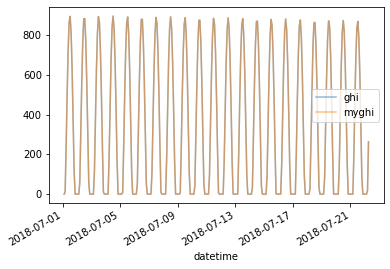

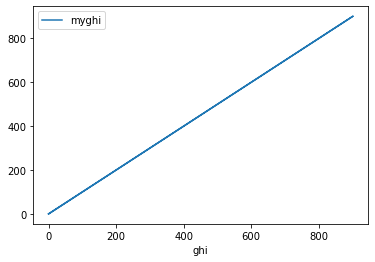

In [53]:
df_ghi.iloc[:5000:20].plot(alpha=0.5)
df_ghi.plot(x='ghi', y='myghi')

## Transform data with GHI
<a id='ghi_transform'></a>

In [54]:
from sklearn.base import TransformerMixin


class ghi_scalar(TransformerMixin):
    """Normalise data with respect to the Global Horizontal 
    Irradience (GHI)"""
    
    def __init__(self, lats, lons, g0=0):
        assert lats.shape==lons.shape
        self.lats = lats
        self.lons = lons
        self.g0 = g0
        
    def haurwitz_ghi(self, times):
        apparent_zenith = spa_python(times, self.lats, self.lons,
                   altitude=0, pressure=101325, temperature=12, delta_t=67.0,
                   atmos_refract=None, numthreads=3)
        return haurwitz(apparent_zenith) + self.g0

    def transform(self, X):
        '''Divides by the GHI at each loaction and time
        X must be dataframe with datetime index'''
        assert len(self.lats)==X.shape[1]
        GHI = self.haurwitz_ghi(X.index)
        return X/GHI
    
    def inverse_transform(self, X):
        '''Multiplies by the GHI at each loaction and time
        X must be dataframe with datetime index'''        
        assert len(self.lats)==X.shape[1]
        GHI = self.haurwitz_ghi(X.index)
        return X*GHI

In [55]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME) #reload data to undo transforms

CPU times: user 14.4 s, sys: 2.05 s, total: 16.5 s
Wall time: 16.5 s


In [56]:
# redo some pre-processing steps seen before
pv_power_selected = pv_power.loc[dict(datetime=slice('2018-07-01', '2019-07-10'))]
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0)
pv_power_df.columns = pv_power_df.columns.astype(int)
pv_power_df = pv_power_df.tz_localize('Europe/London').tz_convert('UTC')
pv_power_df[30248]['2018-10-29':'2019-01-03'] = np.NaN
pv_power_df[22903]['2018-08-08'] = np.NaN
del pv_power
del pv_power_selected

pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)

__Problem :__ dividing by zero GHI

The solar output does not fall to exactly zero when GHI goes to zero. This could be due to streetlights, moonlight, the approximations in computing GHI or just timing issues of the panels. To address this I am going to modify the modellig equation to add a fudge factor ($g_0$) to GHI to set a lower limit. This factor could be learned but for now I set it to 10 as in general GHI is in range [100-900] so this seems reasonable.

$$PV = \left(GHI(t, \theta) + g_0 \right)A(\lambda)k(x)$$

In [57]:
lats, lons = pv_metadata.loc[pv_power_df.columns, ['latitude', 'longitude']].T.values
ghi = ghi_scalar(lats, lons, g0=10)

In [58]:
%%time
pv_power_div_ghi_df = ghi.transform(pv_power_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Reloading spa to use numba


CPU times: user 1min 14s, sys: 2.62 s, total: 1min 17s
Wall time: 31.6 s


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1446088.,  926699., 1188924., 1361527., 1449543., 1473199.,
        1444393., 1386860., 1319716., 1247164., 1170797., 1097801.,
        1008389.,  929045.,  854363.,  787721.,  730482.,  673635.,
         627907.,  584737.,  552350.,  521439.,  496535.,  478288.,
         455091.,  438878.,  423381.,  407597.,  395875.,  382887.,
         369204.,  353295.,  338022.,  324503.,  308209.,  292580.,
         273768.,  255482.,  237970.,  220936.,  208902.,  194184.,
         179055.,  166283.,  154950.,  144745.,  134521.,  126767.,
         118215.,  110964.,  104416.,   99388.,   93345.,   88479.,
          83930.,   79489.,   74459.,   70489.,   66951.,   64040.,
          59563.,   56445.,   53987.,   50608.,   48165.,   45521.,
          43070.,   40980.,   39013.,   37102.,   34741.,   33715.,
          31688.,   30241.,   29106.,   27370.,   26049.,   24880.,
          23347.,   22381.,   21349.,   20311.,   19172.,   18790.,
          17411.,   16699.,   16010.,   15348., 

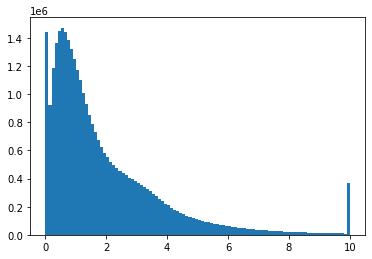

In [59]:
# Filter to where the sun is shining
ghi_vals = ghi.haurwitz_ghi(pv_power_div_ghi_df.index)
pv_power_div_ghi_df = pv_power_div_ghi_df.where(ghi_vals>ghi.g0)
plt.hist(pv_power_div_ghi_df.clip(0,1e1).values.ravel(), bins=100)

## How linear are GHI and power output?

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


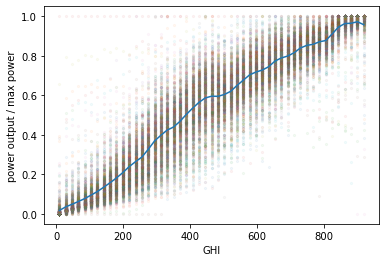

In [60]:
bins = np.linspace(0,930,50)

for i in range(pv_power_df.shape[1]):
    
    x = pv_power_df.iloc[:, i].groupby(pd.cut(ghi_vals[:,i], bins)).agg(lambda x :np.nanpercentile(x, 80))
    
    x /= np.nanpercentile(x, 100)
    x = x.clip(0,10)
    if i==0: binmeans = pd.DataFrame(x)
    else: binmeans = binmeans.join(x)
    plt.scatter([v.mid for v in x.index], x.values, alpha=0.05, s=5)
    
binmeans.index.name = 'GHI'
plt.plot([v.mid for v in binmeans.index], binmeans.mean(axis=1))
plt.ylabel('power output / max power')
plt.xlabel('GHI')
plt.show()

## Load satellite data
<a id='load_sat'></a>

In [61]:
from glob import glob
from torch.utils.data import Dataset
from datetime import datetime

In [62]:
RECTANGLE_WIDTH_M = 128000 # in meters
RECTANGLE_HEIGHT_M = RECTANGLE_WIDTH_M

METERS_PER_PIXEL = 1000
RECTANGLE_WIDTH_PIXELS = RECTANGLE_WIDTH_M // METERS_PER_PIXEL
RECTANGLE_HEIGHT_PIXELS = RECTANGLE_HEIGHT_M // METERS_PER_PIXEL

SAT_IMAGE_MEAN = 20.444992
SAT_IMAGE_STD = 8.766013


def get_rectangle(data_array, centre_x, centre_y, width=RECTANGLE_WIDTH_M, height=RECTANGLE_HEIGHT_M):
    half_width = width / 2
    half_height = height / 2

    north = centre_y + half_height
    south = centre_y - half_height
    east = centre_x + half_width
    west = centre_x - half_width

    return data_array.loc[dict(
        x=slice(west, east), 
        y=slice(north, south))]


class SatelliteLoader(Dataset):
    """
    Attributes:
        index: pd.Series which maps from UTC datetime to full filename of satellite data.
        _data_array_cache: The last lazily opened xr.DataArray that __getitem__ was asked to open.
            Useful so that we don't have to re-open the DataArray if we're asked to get
            data from the same file on several different calls.
    """
    def __init__(self, file_pattern):
        self._load_sat_index(file_pattern)
        self._data_array_cache = None
        self._last_filename_requested = None
        
    def __getitem__(self, dt: datetime) -> xr.DataArray:
        """Returns lazily-opened DataArray"""
        sat_filename = self.index[dt]
        if sat_filename != self._last_filename_requested:
            self._data_array_cache = xr.open_dataarray(sat_filename)
            self._last_filename_requested = sat_filename
        return self._data_array_cache.sel(time=dt)
    
    def close(self):
        if self._data_array_cache is not None:
            self._data_array_cache.close()
        
    def __len__(self):
        return len(self.index)
        
    def _load_sat_index(self, file_pattern):
        """Opens all satellite files in `file_pattern` and loads all their datetime indicies into self.index."""
        sat_filenames = glob(file_pattern)
        sat_filenames.sort()
        
        n_filenames = len(sat_filenames)
        sat_index = []
        for i_filename, sat_filename in enumerate(sat_filenames):
            if i_filename % 10 == 0 or i_filename == (n_filenames - 1):
                print('\r {:5d} of {:5d}'.format(i_filename + 1, n_filenames), end='', flush=True)
            data_array = xr.open_dataarray(sat_filename, drop_variables=['x', 'y'])
            sat_index.extend([(sat_filename, t) for t in data_array.time.values])

        sat_index = pd.DataFrame(sat_index, columns=['filename', 'datetime']).set_index('datetime').squeeze()
        assert not any(sat_index.index.duplicated())
        self.index = sat_index.tz_localize('UTC')
        
    def get_rectangles_for_all_data(self, centre_x, centre_y, width=RECTANGLE_WIDTH_M, height=RECTANGLE_HEIGHT_M):
        """Iterate through all satellite filenames and load rectangle of imagery."""
        sat_filenames = np.sort(np.unique(self.index.values))
        for sat_filename in sat_filenames:
            data_array = xr.open_dataarray(sat_filename)
            yield get_rectangle(data_array, time, centre_x, centre_y, width, height)
        
    def get_rectangle(self, time, centre_x, centre_y, width=RECTANGLE_WIDTH_M, height=RECTANGLE_HEIGHT_M):
        data_array = self[time]
        return get_rectangle(data_array, centre_x, centre_y, width, height)

In [63]:
%%time
sat_loader = SatelliteLoader(os.path.join(SATELLITE_DATA_PATH, '*.nc'))
print()

   189 of   189
CPU times: user 876 ms, sys: 32 ms, total: 908 ms
Wall time: 5.71 s


In [64]:
sat_loader.index

datetime
2018-07-01 03:25:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
2018-07-01 03:30:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
2018-07-01 03:35:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
2018-07-01 03:40:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
2018-07-01 03:45:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
                                                   ...                        
2018-07-10 20:35:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
2018-07-10 20:40:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
2018-07-10 20:45:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
2018-07-10 20:50:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
2018-07-10 20:55:00+00:00    /home/davidjamesfulton93/repos/predict_pv_yiel...
Name: filename, Length: 2252, dtype: object

In [65]:
len(sat_loader)

2252

## Plot a test

In [66]:
# Test get rectangle
dt = pd.Timestamp('2018-07-09 10:15')
pv_system_id = pv_metadata.index[1]
x, y = pv_metadata.loc[pv_system_id][['x', 'y']]

In [67]:
%%time
sat_data = sat_loader.get_rectangle(time=dt, centre_x=x, centre_y=y) #, width=512000, height=512000)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 31.8 ms


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  


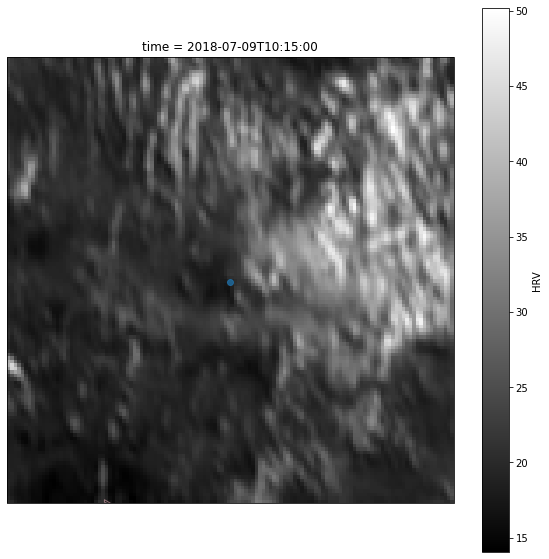

In [68]:
fig = plt.figure(figsize=(10, 10))
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

sat_data.plot.imshow(ax=ax, cmap='gray', origin='upper', add_colorbar=True)
ax.scatter(x=x, y=y, alpha=0.7);

## Align satellite datetime index with PV datetime index

In [69]:
# Mask non-daylight hours and drop times and systems with no
#    daylight data.
daylight_mask = ghi_vals > ghi.g0
pv_target = pv_power_div_ghi_df.where(daylight_mask)#.dropna(how='all',axis=0).dropna(how='all',axis=1)


rminmaxscal = RobustMinMaxScaler(saturation_fraction=0.01)
pv_target = pd.DataFrame(rminmaxscal.fit_transform(pv_target), 
                         index=pv_target.index,
                         columns=pv_target.columns)

ghi_df = pd.DataFrame(ghi_vals, index = pv_power_div_ghi_df.index, columns = pv_power_div_ghi_df.columns)


In [106]:
del pv_data_for_dt, pv_data_to_plot, pv_data_to_plot_hour_system_means, pv_data_to_plot_hour_mean, df_, daylight_mask, clearsky, myghi, 

In [ ]:
del ghi_vals
del pv_power_div_ghi_df
del pv_power_df

In [107]:
import gc
gc.collect()

40495

In [108]:
pv_target.max()

690      0.449025
709      0.624295
973      0.374917
1364     1.000000
1556     0.546934
           ...   
68218         NaN
68219         NaN
68324         NaN
68404         NaN
68443         NaN
Length: 903, dtype: float64

In [109]:
datetime_index = pv_target.index[~np.all(pv_target.isna(), axis=1)].intersection(sat_loader.index.index)

In [110]:
pv_target = pv_target.reindex(datetime_index)
ghi_df = ghi_df.reindex(datetime_index)

In [111]:
len(datetime_index)

2099

In [112]:
datetime_index.tz

<UTC>

In [113]:
# Split train & test by days
days = np.unique(datetime_index.date)
len(days)

10

In [114]:
# Use every 5th day for testing
testing_days = days[::5]
len(testing_days)

2

In [115]:
training_days = np.array(list(set(days) - set(testing_days)))
training_days = np.sort(training_days)
len(training_days)

8

In [116]:
def get_datetime_index_for_days(training_or_testing_days):
    return datetime_index[pd.Series(datetime_index.date).isin(training_or_testing_days)]

training_datetimes = get_datetime_index_for_days(training_days)
testing_datetimes = get_datetime_index_for_days(testing_days)
assert not set(training_datetimes).intersection(testing_datetimes)

len(training_datetimes), len(testing_datetimes)

(1687, 412)

### Load testing batch
<a id='load_batches'></a>

In [117]:
import torch

In [118]:
def new_full_array(size, fill_value=np.NaN, dtype=np.float16):
    return np.full(shape=size, fill_value=fill_value, dtype=dtype)

In [119]:
TESTING_BATCH_SIZE = 256

In [82]:
testing_batch = {
    'sat_images': new_full_array(
        size=(TESTING_BATCH_SIZE, 1, RECTANGLE_WIDTH_PIXELS, RECTANGLE_HEIGHT_PIXELS),
        dtype=np.float32),  # use float32 to minimise problems with normalisation
    'pv_yield': new_full_array(size=(TESTING_BATCH_SIZE, 1)),
    'pv_system_id': np.zeros(shape=TESTING_BATCH_SIZE, dtype=np.int32),
    'datetime_index': testing_datetimes[:TESTING_BATCH_SIZE],
    'loss_weight': new_full_array(size=(TESTING_BATCH_SIZE, 1))}

In [83]:
for i, dt in enumerate(testing_batch['datetime_index']):
    # Randomly sample from PV systems which have data for this datetime
    pv_data_for_dt = pv_target.loc[dt].dropna()
    pv_system_id = np.random.choice(pv_data_for_dt.index)
    pv_yield = pv_data_for_dt[pv_system_id]
    loss_weight = ghi_df.loc[dt][pv_system_id]
    
    # Load satellite image
    x, y = pv_metadata.loc[pv_system_id][['x', 'y']]
    sat_data = sat_loader.get_rectangle(time=dt, centre_x=x, centre_y=y)
    
    # Put into super batch
    testing_batch['sat_images'][i, 0] = sat_data.values
    testing_batch['pv_yield'][i, 0] = pv_yield
    testing_batch['loss_weight'][i, 0] = loss_weight
    testing_batch['pv_system_id'][i] = pv_system_id


In [84]:
# Normalise satellite images
testing_batch['sat_images'] -= SAT_IMAGE_MEAN
testing_batch['sat_images'] /= SAT_IMAGE_STD

## Load training super batch

In [85]:
N_RECTANGLES_PER_SAT_IMAGE = 32
N_DATETIMES_PER_SUPERBATCH = 4096

SUPER_BATCH_SIZE = N_RECTANGLES_PER_SAT_IMAGE * N_DATETIMES_PER_SUPERBATCH
BYTES_PER_PIXEL = 2  # float16
size_of_each_image_mb = (RECTANGLE_HEIGHT_PIXELS * RECTANGLE_WIDTH_PIXELS * BYTES_PER_PIXEL) / 1E6
super_batch_size_mb = size_of_each_image_mb * SUPER_BATCH_SIZE
print('Size of super batch: {:8.1f} MB'.format(super_batch_size_mb))
print('                     {:6d}   examples'.format(SUPER_BATCH_SIZE))

Size of super batch:   4295.0 MB
                     131072   examples


### Load CPU super batch from individual images

In [86]:
%%time
cpu_super_batch = {
    'sat_images': new_full_array(
        size=(SUPER_BATCH_SIZE, 1, RECTANGLE_WIDTH_PIXELS, RECTANGLE_HEIGHT_PIXELS), 
        dtype=np.float32),  # use float32 to minimise issues with normalisation
    'pv_yield': new_full_array(size=(SUPER_BATCH_SIZE, 1)),
    'loss_weight': new_full_array(size=(SUPER_BATCH_SIZE, 1)),
    'pv_system_id': np.zeros(shape=SUPER_BATCH_SIZE, dtype=np.int32),
    'datetime_index': np.zeros(shape=SUPER_BATCH_SIZE, dtype='datetime64[s]'),
    }

CPU times: user 584 ms, sys: 1.52 s, total: 2.1 s
Wall time: 2.1 s


In [87]:
HALF_RECTANGLE_WIDTH_M = RECTANGLE_WIDTH_M / 2
HALF_RECTANGLE_HEIGHT_M = RECTANGLE_HEIGHT_M / 2

def load_data_into_cpu_super_batch():
    # Get datetimes for superbatch by randomly sampling
    super_batch_datetimes = np.random.choice(training_datetimes.to_numpy(dtype=object), size=N_DATETIMES_PER_SUPERBATCH)
    super_batch_datetimes = np.sort(super_batch_datetimes)
    super_batch_datetimes = pd.DatetimeIndex(super_batch_datetimes)
    cpu_super_batch['datetime_index'] = np.zeros(shape=SUPER_BATCH_SIZE, dtype='datetime64[s]')
    
    # Load satellite data and PV data
    for image_i, dt in enumerate(super_batch_datetimes):
        print('\r{:6d} of {:d}'.format(image_i+1, N_DATETIMES_PER_SUPERBATCH), end='', flush=True)

        # Randomly sample from PV systems which have data for this datetime
        # Loop because we sat images (very rarely) have NaNs, in which case we need to pick another random datetime
        while True:
            pv_data_for_dt = pv_target.loc[dt].dropna()
            loss_weight_for_dt = ghi_df.loc[dt]
            replace = len(pv_data_for_dt) < N_RECTANGLES_PER_SAT_IMAGE
            pv_system_ids = np.random.choice(pv_data_for_dt.index, size=N_RECTANGLES_PER_SAT_IMAGE, replace=replace)
            locations = pv_metadata.loc[pv_system_ids][['x', 'y']]
            

            # Get bounding box
            north = locations['y'].max() + HALF_RECTANGLE_HEIGHT_M
            south = locations['y'].min() - HALF_RECTANGLE_HEIGHT_M
            west = locations['x'].min() - HALF_RECTANGLE_WIDTH_M
            east = locations['x'].max() + HALF_RECTANGLE_WIDTH_M

            # Load satellite images
            # Very rarely images are NaN, so we need to handle that case
            data_array = sat_loader[dt]
            data_array = data_array.loc[dict(
                x=slice(west, east), 
                y=slice(north, south))]
            data_array = data_array.load()
            
            if np.any(np.isnan(data_array.values)):
                print('\nSat image for', dt, 'has NaNs!  Picking another datetime!')
                dt = np.random.choice(training_datetimes.to_numpy(dtype=object))
            else:
                break                 

        example_i = image_i * N_RECTANGLES_PER_SAT_IMAGE
        for pv_system_id, row in locations.iterrows():
            sat_data = get_rectangle(data_array, centre_x=row.x, centre_y=row.y)
            pv_yield = pv_data_for_dt[pv_system_id]
            loss_weight =  loss_weight_for_dt[pv_system_id]

            # Put into super batch
            cpu_super_batch['sat_images'][example_i, 0] = sat_data.values
            cpu_super_batch['pv_yield'][example_i, 0] = pv_yield
            cpu_super_batch['loss_weight'][example_i, 0] = loss_weight
            cpu_super_batch['pv_system_id'][example_i] = pv_system_id
            cpu_super_batch['datetime_index'][example_i] = dt.to_numpy()  # TODO: Maybe move this to a vectorised solution?
            example_i += 1
            
    cpu_super_batch['datetime_index'] = pd.DatetimeIndex(cpu_super_batch['datetime_index'], tz='UTC')

    # Normalise satellite images
    cpu_super_batch['sat_images'] -= SAT_IMAGE_MEAN
    cpu_super_batch['sat_images'] /= SAT_IMAGE_STD

    print()
    return cpu_super_batch

In [88]:
%%time
cpu_super_batch = load_data_into_cpu_super_batch()

  4096 of 4096
CPU times: user 3min 46s, sys: 7.7 s, total: 3min 54s
Wall time: 7min 23s


### Compute hour of day and clearsky

In [89]:
HOURS_OF_DAY_MEAN = 11.628418
HOURS_OF_DAY_STD = 4.1584363

def compute_hour_of_day(batch_dict):
    hours_of_day = batch_dict['datetime_index'].hour.values.astype(np.float32)
    hours_of_day -= HOURS_OF_DAY_MEAN
    hours_of_day /= HOURS_OF_DAY_STD
    batch_dict['hours_of_day'] = hours_of_day[:, np.newaxis]
    return batch_dict

In [90]:
cpu_super_batch = compute_hour_of_day(cpu_super_batch)

In [91]:
testing_batch = compute_hour_of_day(testing_batch)

#### Clearsky

In [92]:
CLEARSKY_MEAN = np.array([373.1623 , 538.70374,  80.82757], dtype=np.float32)
CLEARSKY_STD = np.array([268.6872  , 254.62102 ,  42.651264], dtype=np.float32)

def compute_clearsky(batch_dict):
    '''Adds DRI, DFI and GHI to batch input dictionary'''
    n_examples = len(batch_dict['datetime_index'])
    clearsky = np.full(shape=(n_examples, 3), fill_value=np.NaN, dtype=np.float32)
    pv_ids_and_datetimes = pd.DataFrame(
        {'pv_system_id': batch_dict['pv_system_id'], 
         'datetime_index': batch_dict['datetime_index']})
    
    for pv_system_id, df in pv_ids_and_datetimes.groupby('pv_system_id'):
        dt_index = pd.DatetimeIndex(df['datetime_index'])
        location = get_pvlib_location(pv_system_id)
        clearsky_for_location = location.get_clearsky(dt_index)
        clearsky[df.index] = clearsky_for_location.values

    assert not any(np.isnan(clearsky).flatten())
    
    clearsky -= CLEARSKY_MEAN
    clearsky /= CLEARSKY_STD
    
    batch_dict['clearsky'] = clearsky
    return batch_dict

In [93]:
%%time
cpu_super_batch = compute_clearsky(cpu_super_batch)

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:258: UserWarning: Reloading spa to use numpy
  warnings.warn('Reloading spa to use numpy')


CPU times: user 19.7 s, sys: 28 ms, total: 19.7 s
Wall time: 20 s


In [94]:
%%time
testing_batch = compute_clearsky(testing_batch)

CPU times: user 4.38 s, sys: 12 ms, total: 4.39 s
Wall time: 4.38 s


## Check 

In [95]:
def check_super_batch(batch_dict):
    dict_keys_with_nans = []
    for k, v in batch_dict.items():
        if k != 'datetime_index' and np.any(np.isnan(v)):
            dict_keys_with_nans.append(k)
    if dict_keys_with_nans:
        raise ValueError('These super batch keys have NaNs!  {}'.format(dict_keys_with_nans))

In [96]:
%%time
check_super_batch(cpu_super_batch)

CPU times: user 1.07 s, sys: 2.74 s, total: 3.82 s
Wall time: 3.82 s


### GPU super batch

In [97]:
from copy import copy

In [98]:
def new_full_tensor(size, fill_value=np.NaN, dtype=torch.float16, device='cuda'):
    return torch.full(size=size, fill_value=fill_value, dtype=dtype, device=device)

In [99]:
%%time
gpu_super_batch = {
    'sat_images': new_full_tensor(
        size=(SUPER_BATCH_SIZE, 1, RECTANGLE_WIDTH_PIXELS, RECTANGLE_HEIGHT_PIXELS)),
    'pv_yield': new_full_tensor(size=(SUPER_BATCH_SIZE, 1)),
    'loss_weight': new_full_tensor(size=(SUPER_BATCH_SIZE, 1)),
    'hours_of_day': new_full_tensor(size=(SUPER_BATCH_SIZE, 1)),
    'clearsky': new_full_tensor(size=(SUPER_BATCH_SIZE, 3))
}

CPU times: user 2.14 s, sys: 972 ms, total: 3.11 s
Wall time: 6.41 s


In [100]:
def move_superbatch_to_gpu(cpu_super_batch):
    for k, v in cpu_super_batch.items():
        if k in ['datetime_index', 'pv_system_id']:
            gpu_super_batch[k] = copy(v)
        else:
            try:
                gpu_super_batch[k].copy_(torch.HalfTensor(v))
            except:
                print('Problem with', k)
                raise

    return gpu_super_batch

In [120]:
%%time
gpu_super_batch = move_superbatch_to_gpu(cpu_super_batch)

CPU times: user 3.06 s, sys: 1.94 s, total: 4.99 s
Wall time: 2.96 s


In [121]:
# Move testing batch into GPU memory
for key in ['sat_images', 'pv_yield', 'hours_of_day', 'clearsky', 'loss_weight']:
    testing_batch[key] = torch.cuda.HalfTensor(testing_batch[key])

## Define neural net and train
<a id='net'></a>

In [122]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [123]:
class Net(nn.Module):
    def __init__(self, dropout_proportion=0.1):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5)
        HOURS_OF_DAY_CHANNELS = 1
        CLEARSKY_CHANNELS = 3
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120 + HOURS_OF_DAY_CHANNELS + CLEARSKY_CHANNELS, 84)
        self.fc3 = nn.Linear(84, 1)
        self.dropout_layer = nn.Dropout(p=dropout_proportion)

    def forward(self, x, hour_of_day, clearsky):
        #x = self.dropout_layer(x)
        x = self.pool(F.relu(self.conv1(x)))
        # x is now <batch_size>, 6, 62, 62.  
        # 62 is 124 / 2.  124 is the 128-dim input - 4
        x = self.dropout_layer(x)
        x = self.pool(F.relu(self.conv2(x)))
        # x is now <batch_size>, 16, 29, 29
        x = x.view(-1, 16 * 29 * 29)
        # x is now <batch_size>, 16 x 29 x 29
        x = self.dropout_layer(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_layer(x)
        x = torch.cat((x, hour_of_day, clearsky), dim=1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

net = Net().cuda().half()

In [124]:
net

Net(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=124, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
)

In [125]:

def WeightedL1Loss(input, target, weight):
    weight = weight / 100 # this is important for overflow if in units of Wm^-2
    norm = torch.mean(weight)
    return F.l1_loss(input*weight, target*weight, reduction='mean')/norm


def WeightedMSELoss(input, target, weight):
    weight = weight / 100 # this is important for overflow if in units of Wm^-2
    norm = torch.mean(weight**2)
    return F.mse_loss(input*weight, target*weight, reduction='mean')/norm

def backwardCompatMAE(input, target, weight):
    weight = weight / 909 
    return F.l1_loss(input*weight, target*weight, reduction='mean')


In [126]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
#loss_func = lambda input, target, weight: nn.MSELoss()(input, target)
#mae_loss_func = lambda input, target, weight: nn.L1Loss()(input, target)

mae_loss_func = WeightedL1Loss
loss_func = WeightedMSELoss

In [127]:
train_losses = []
train_mae_losses = []
test_losses = []
test_mae_losses = []

training_index_len_minus_1 = SUPER_BATCH_SIZE - 1

In [128]:
TRAINING_BATCH_SIZE = 128

BATCHES_PER_EPOCH = SUPER_BATCH_SIZE // TRAINING_BATCH_SIZE
STATS_PERIOD = BATCHES_PER_EPOCH // 4
N_EPOCHS = 7
N_LOADS = 7
N_BATCHES_TO_TRAIN = BATCHES_PER_EPOCH * N_EPOCHS

TESTING_INPUTS = testing_batch['sat_images']
TESTING_TARGET = testing_batch['pv_yield']
TESTING_HOURS_OF_DAY = testing_batch['hours_of_day']
TESTING_CLEARSKY = testing_batch['clearsky']
TESTING_WEIGHT = testing_batch['loss_weight']

In [129]:
net

Net(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=124, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
)

In [130]:
%%time

achieved_good_test_mae = False

for i_load in range(N_LOADS):
    print('loading', i_load + 1, 'of', N_LOADS)
    t0 = time.time()
    running_train_loss = 0.0
    running_train_mae = 0.0
    for i_batch in range(N_BATCHES_TO_TRAIN):
        print('\rBatch: {:4d} of {}'.format(i_batch + 1, N_BATCHES_TO_TRAIN), end='', flush=True)

        # Create batch
        batch_index = np.random.randint(low=0, high=training_index_len_minus_1, size=TRAINING_BATCH_SIZE)
        inputs = gpu_super_batch['sat_images'][batch_index]
        hours_of_day_for_batch = gpu_super_batch['hours_of_day'][batch_index]
        clearsky_for_batch = gpu_super_batch['clearsky'][batch_index]
        target = gpu_super_batch['pv_yield'][batch_index]
        weight = gpu_super_batch['loss_weight'][batch_index]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        net.train()
        outputs = net(inputs, hours_of_day_for_batch, clearsky_for_batch)
        train_loss = loss_func(outputs, target, weight)
        train_loss.backward()
        optimizer.step()
        running_train_loss += train_loss.item()

        # MAE
        train_mae = mae_loss_func(outputs, target, weight)
        running_train_mae += train_mae.item()

        # print statistics
        if i_batch == 0 or i_batch % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches
            t1 = time.time()

            # Train loss
            if i_batch == 0:
                mean_train_loss = running_train_loss
                mean_train_mae = running_train_mae
            else:
                mean_train_loss = running_train_loss / STATS_PERIOD
                mean_train_mae = running_train_mae / STATS_PERIOD

            train_losses.append(mean_train_loss)
            train_mae_losses.append(mean_train_mae)

            # Test loss
            net.eval()
            test_outputs = net(TESTING_INPUTS, TESTING_HOURS_OF_DAY, TESTING_CLEARSKY)
            test_loss = loss_func(test_outputs, TESTING_TARGET, TESTING_WEIGHT).item()
            test_losses.append(test_loss)
            test_mae = mae_loss_func(test_outputs, TESTING_TARGET, TESTING_WEIGHT).item()
            test_mae_losses.append(test_mae)

            print(
                '\n        time =   {:.2f} milli seconds per batch.\n'
                '   train loss = {:8.5f}\n'
                '    train MAE = {:8.5f}\n'
                '    test loss = {:8.5f}\n'
                '     test MAE = {:8.5f}'.format(
                    ((t1 - t0) / STATS_PERIOD) * 1000,
                    mean_train_loss, 
                    mean_train_mae,
                    test_loss,
                    test_mae
                ))
            running_train_loss = 0.0
            running_train_mae = 0.0
            t0 = time.time()
            
            # Break if test MAE suddenly spikes up
            if test_mae < 0.10:
                achieved_good_test_mae = True
            if achieved_good_test_mae and test_mae > 0.11:
                print('Eak!  Test MAE has spiked up!')
                break
          
    print()
    if i_load < N_LOADS - 1:
        print('Loading new data!')
        cpu_super_batch = load_data_into_cpu_super_batch()
        cpu_super_batch = compute_hour_of_day(cpu_super_batch)
        cpu_super_batch = compute_clearsky(cpu_super_batch)
        check_super_batch(cpu_super_batch)
        gpu_super_batch = move_superbatch_to_gpu(cpu_super_batch)

print()
print('Finished Training')

loading 1 of 7
Batch:    1 of 7168
        time =   4.36 milli seconds per batch.
   train loss =  0.15979
    train MAE =  0.31445
    test loss =  0.11401
     test MAE =  0.28027
Batch:  256 of 7168
        time =   24.54 milli seconds per batch.
   train loss =  0.03091
    train MAE =  0.13701
    test loss =  0.02054
     test MAE =  0.11420
Batch:  512 of 7168
        time =   24.46 milli seconds per batch.
   train loss =  0.02670
    train MAE =  0.12848
    test loss =  0.01886
     test MAE =  0.11023
Batch:  768 of 7168
        time =   24.50 milli seconds per batch.
   train loss =  0.02642
    train MAE =  0.12746
    test loss =  0.01851
     test MAE =  0.10913
Batch: 1024 of 7168
        time =   24.65 milli seconds per batch.
   train loss =  0.02635
    train MAE =  0.12788
    test loss =  0.01804
     test MAE =  0.10724
Batch: 1280 of 7168
        time =   24.76 milli seconds per batch.
   train loss =  0.02568
    train MAE =  0.12625
    test loss =  0.01819
   

KeyboardInterrupt: 

In [131]:
backwardCompatMAE(test_outputs, TESTING_TARGET, TESTING_WEIGHT)

tensor(0.0533, device='cuda:0', dtype=torch.float16, grad_fn=<L1LossBackward>)

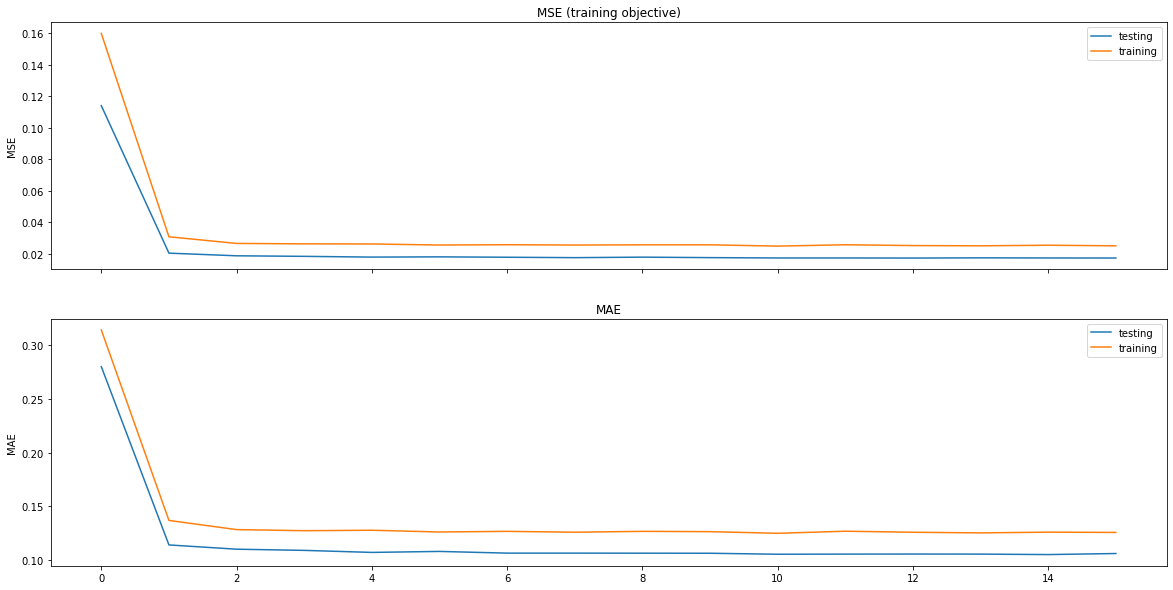

In [132]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))

ax1.plot(test_losses, label='testing')
ax1.plot(train_losses, label='training')
ax1.set_title('MSE (training objective)')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.plot(test_mae_losses, label='testing')
ax2.plot(train_mae_losses, label='training')
ax2.set_title('MAE')
ax2.set_ylabel('MAE')
ax2.legend();

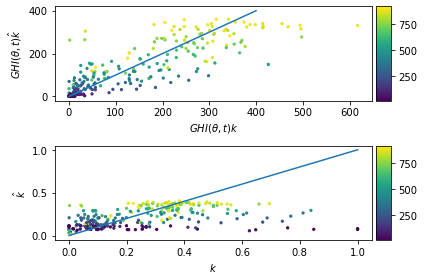

In [133]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, (ax1, ax2) = plt.subplots(2,1)
z1 = ax1.scatter((TESTING_TARGET*TESTING_WEIGHT).cpu().detach().numpy(), (test_outputs*TESTING_WEIGHT).cpu().detach().numpy(), s=5,c=TESTING_WEIGHT.cpu().detach().numpy())
ax1.set_xlabel(r'$GHI( \theta, t)k$')
ax1.set_ylabel(r'$GHI( \theta, t)\hat{k}$')
ax1.plot([0,400], [0,400])
plt.colorbar(z1, make_axes_locatable(ax1).append_axes("right", size="5%", pad=0.05))


z2 = ax2.scatter(TESTING_TARGET.cpu().detach().numpy(), test_outputs.cpu().detach().numpy(), s=5,c=TESTING_WEIGHT.cpu().detach().numpy())
ax2.set_xlabel(r'$k$')
ax2.set_ylabel(r'$\hat{k}$')
ax2.plot([0,1], [0,1])
plt.colorbar(z2,  make_axes_locatable(ax2).append_axes("right", size="5%", pad=0.05))

plt.tight_layout()
plt.show()

In [134]:
# fractional difference in the sum of predictions and targets
# this is the most important thing for estimating GCP power
((test_outputs*TESTING_WEIGHT).mean() - (TESTING_TARGET*TESTING_WEIGHT).mean())/(TESTING_TARGET*TESTING_WEIGHT).mean()

tensor(-0.0604, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)

Timestamp('2018-07-08 11:05:00+0000', tz='UTC')

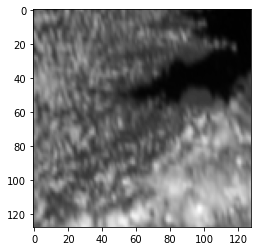

In [117]:
i = 70
plt.imshow(cpu_super_batch['sat_images'][batch_index][i, 0].astype(np.float32), cmap='gray')
dt = cpu_super_batch['datetime_index'][batch_index]
dt[i]